In [1]:
import collections
import csv
import keras
import keras.backend as K
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import time
import shap
import ROOT as root
from sklearn.preprocessing import StandardScaler

from keras import optimizers
from keras.regularizers import l2
from keras.layers import Dense, LayerNormalization, BatchNormalization, Dropout, GaussianNoise, Activation, Add
from keras import activations
from ROOT import TFile, TLorentzVector

from tools.constants import *

Welcome to JupyROOT 6.22/08


In [2]:
""" Data augmentation. """
def random_rotation(X,deltas_phi,num_vectors,met):

    for i in range(num_vectors):
        
        R = np.sqrt((X[:,4*i+0]**2 + X[:,4*i+1]**2))
        old_phis = np.arctan2(X[:,4*i+1],X[:,4*i+0])
        new_phis = old_phis + deltas_phi

        angles_sin = np.sin(new_phis)
        angles_cos = np.cos(new_phis)

        X[:,4*i+0] = angles_cos * R
        X[:,4*i+1] = angles_sin * R
        
    if met:
        return random_rotation_MET(X, deltas_phi)
    else:
        return X


def random_rotation_MET(X, deltas_phi):

    R = np.sqrt((X[:,-11]**2 + X[:,-10]**2))
    old_phis = np.arctan2(X[:,-10],(X[:,-11]))
    new_phis = old_phis + deltas_phi

    angles_sin = np.sin(new_phis)
    angles_cos = np.cos(new_phis)

    X[:,-11] = angles_cos * R
    X[:,-10] = angles_sin * R

    return X


def data_rotation(X, num_vectors_X = 11, met = True):   
    
    deltas_phi = np.random.rand(X.shape[0])*2*math.pi
    X = random_rotation(X,deltas_phi,num_vectors_X,met)
        
    return X

""" Data generator for serving the NN data. """
# modified from source: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, scaler = ["scaler_params/X_scaler_mass_reco_full_real.csv","scaler_params/y_scaler_higgs_masses_full_real.csv"], batch_size=32, n_features=72, shuffle=True, augmentation = True, ceil = False):
        self.n_features = n_features
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.ceil = ceil
        self.indexes = np.arange(len(X))
        with open(scaler[0]) as f:
            scaler_params = np.loadtxt(f, delimiter=",")
            self.X_scaler = scaler_params[0:2,:]
        with open(scaler[1]) as f:
            scaler_params = np.loadtxt(f, delimiter=",")
            self.y_scaler = scaler_params[0:2]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.ceil:
            return int(np.ceil(len(self.X) / self.batch_size))
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y, weights = self.__data_generation(indexes)
        return X, y, weights

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)

        X = self.X[indexes]

        weights = X[:,-1]
        X = X[:,:-1]

        y = self.y[indexes]

        if self.augmentation:
            X = data_rotation(X, num_vectors_X = 11, met = True)
        X = (X-self.X_scaler[0])/self.X_scaler[1]     # Standardize
        y = (y-self.y_scaler[0])/self.y_scaler[1]     # Standardize

        return X, y, weights
    
    def get_all(self):
        'Get all data - all batches.'
        X = []
        y = []

        for i in range(self.__len__()):
            X_y = self.__getitem__(i)
            X += X_y[0].tolist()
            y += X_y[1].tolist()

        X = np.array(X)
        y = np.array(y)
        
        return X, y

In [3]:
# Load data.

def add_weights(tth):
    """ Class weights, because of the imbalance between the productions' number of events. """
    bg_weight = 1
    h_weight = 1
    
    print(bg_weight)
    print(h_weight)

    ones = np.ones((tth.shape[0],1))
    tth = np.concatenate((tth, h_weight*ones),axis=1)

    return tth

with open("data/mass_reco/mass_reco_input_REAL.csv") as f: 
    data = np.loadtxt(f, delimiter=",", skiprows=1)

data = add_weights(data) 

num_features = data.shape[1]-1   # exclude weights
num_samples = data.shape[0]

print(num_features, num_samples)

1
1
31 101


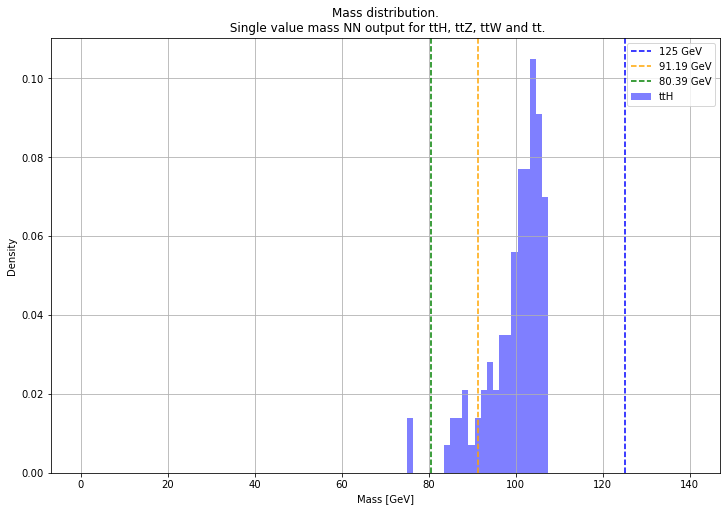

99.66321 6.626335


2022-01-04 17:34:46.453012: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-04 17:34:46.453759: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-04 17:34:46.456743: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-01-04 17:34:47.433925: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-04 17:34:47.434671: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3100000000 Hz


In [4]:
""" Pyplot histogram. """
model = keras.models.load_model("models/mass_reco_full_real")
from scipy.optimize import curve_fit
from scipy.stats import crystalball, norm



ttH_eval_generator = DataGenerator(np.concatenate((data[:,:-10], data[:,-6:]), axis = 1), np.zeros((len(data),1)), n_features = num_features, batch_size=16, shuffle=False, augmentation = False, ceil = True)

ttH_y_pred = model.predict(ttH_eval_generator)
X_y = ttH_eval_generator.get_all()
ttH_X_eval = X_y[0]
ttH_y_true = X_y[1]


""" Scale in the opposite direction, to get the mass in MeV. """
with open("scaler_params/y_scaler_higgs_masses_full_real.csv") as f:
    scaler_params = np.loadtxt(f, delimiter=",")
    y_scaler = scaler_params[0:2]

ttH_y_true = ttH_y_true * y_scaler[1] + y_scaler[0]
ttH_y_pred = ttH_y_pred * y_scaler[1] + y_scaler[0]


with open("scaler_params/X_scaler_mass_reco_full_real.csv") as f:
    scaler_params = np.loadtxt(f, delimiter=",")
    X_scaler = scaler_params[0:2,:]

ttH_X_eval = ttH_X_eval * X_scaler[1] + X_scaler[0]

predicted_higgs_masses = []
predicted_Z_masses = []

VIS_TAU_HADR_INDEX = 12
VIS_TAU_LEP_INDEX = 28

plt.figure(figsize=(12,8))
plt.hist(ttH_y_pred/1000, bins=np.linspace(0,140,100), alpha = 0.5, density = True, color='blue')

plt.axvline(125,color='blue', linestyle='dashed')
plt.axvline(91.19,color='orange', linestyle='dashed')
plt.axvline(80.39,color='green', linestyle='dashed')

plt.title("Mass distribution.\n Single value mass NN output for ttH, ttZ, ttW and tt.")
plt.xlabel("Mass [GeV]")
plt.ylabel("Density")
plt.legend(["125 GeV","91.19 GeV","80.39 GeV","ttH","ttZ","ttW","tt"])
plt.grid()
plt.savefig("figures/mass_histo_full_real_pyplot_.pdf")
plt.show()
print(np.mean(ttH_y_pred/1000), np.std(ttH_y_pred/1000))

In [8]:
""" ROOT histogram. """

import atlasplots as aplt
import root_numpy
from ROOT import TF1, TLine

aplt.set_atlas_style()

H_line = TLine(125.18,0,125.18,10000)
H_line.SetLineStyle(9)
H_line.SetLineWidth(3)
Z_line = TLine(91.19,0,91.19,10000)
Z_line.SetLineStyle(9)
Z_line.SetLineWidth(3)
W_line = TLine(80.38,0,80.38,10000)
W_line.SetLineStyle(9)
W_line.SetLineWidth(3)

gauss_fit_2 = TF1("gauss_fit_2","gaus(0)",80,140)
gauss_fit_2.SetParameters(2000, 110, 10)


ttH = root.TH1F("ttH","",30,60,150)
root_numpy.fill_hist(ttH, ttH_y_pred.flatten()/1000)

fig, ax = aplt.subplots(1, 1)

ttH.Fit("gauss_fit_2","0")
gauss_fit_2.SetNpx(1000)
#ax.plot(gauss_fit_2, label="Fit", labelfmt="L", linecolor=root.kRed+1, linewidth=3)

aplt.atlas_label(text="data", loc="upper left")
ax.text(0.2, 0.84, "2015-2018", size=22, align=13)


ttH_fit = ttH.GetFunction("gauss_fit_2")
print(ttH_fit.GetParameter(0))
print(ttH_fit.GetParameter(1))
print(ttH_fit.GetParameter(2))
#ax.plot(H_line, linecolor='black', label=None, labelfmt="L")
#ax.plot(Z_line, linecolor='black', label=None, labelfmt="L")
#ax.plot(W_line, linecolor='black', label="mass", labelfmt="L")
#ax.plot(null_line, linecolor='black', label=None, labelfmt="L")
ax.plot(ttH, "EP X0", linewidth=1, label=None, labelfmt="EP")
ax.set_xlim(60, 150)
ax.set_ylim(0, 30)
ax.set_xlabel("Mass [GeV]")
ax.set_ylabel("Events")
ax.add_margins(top=0.15)
ax.legend(loc=(0.77, 0.7, 0.85, 0.92))
fig.savefig("figures/mass_histo_full_real_root_scaled_.pdf")

Applying ATLAS style settings
28.407259378604632
113.78125915904005
12.442608303539227
 FCN=7.19077 FROM MIGRAD    STATUS=CONVERGED     136 CALLS         137 TOTAL
                     EDM=3.20164e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.84073e+01   1.69919e+01   4.09949e-03  -3.06283e-05
   2  Mean         1.13781e+02   1.34601e+01   1.48972e-03   1.54258e-04
   3  Sigma        1.24426e+01   5.33024e+00   3.63123e-05  -6.98562e-03


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Warning in <TROOT::Append>: Replacing existing TH1: ttH (Potential memory leak).
Info in <TCanvas::Print>: pdf file figures/mass_histo_full_real_root_scaled_.pdf has been created
